From: https://www.dominodatalab.com/blog/fitting-gaussian-process-models-python

A common applied statistics task involves building regression models to characterize non-linear relationships between variables. It is possible to fit such models by assuming a particular non-linear functional form, such as a sinusoidal, exponential, or polynomial function, to describe one variable's response to the variation in another. Unless this relationship is obvious from the outset, however, it involves possibly extensive model selection procedures to ensure the most appropriate model is retained. Alternatively, a non-parametric approach can be adopted by defining a set of knots across the variable space and use a spline or kernel regression to describe arbitrary non-linear relationships. However, knot layout procedures are somewhat ad hoc and can also involve variable selection. A third alternative is to adopt a Bayesian non-parametric strategy, and directly model the unknown underlying function. For this, we can employ Gaussian process models.

Describing a Bayesian procedure as "non-parametric" is something of a misnomer. The first step in setting up a Bayesian model is specifying a full probability model for the problem at hand, assigning probability densities to each model variable. Thus, it is difficult to specify a full probability model without the use of probability functions, which are parametric! In fact, Bayesian non-parametric methods do not imply that there are no parameters, but rather that the number of parameters grows with the size of the dataset. Rather, Bayesian non-parametric models are infinitely parametric.

# Building models with Gaussians

What if we chose to use Gaussian distributions to model our data?

$$p(x \mid \pi, \Sigma) = (2\pi)^{-k/2}|\Sigma|^{-1/2} \exp\left\{ -\frac{1}{2} (x-\mu)^{\prime}\Sigma^{-1}(x-\mu) \right\}$$

There would not seem to be any gain in doing this, because normal distributions are not particularly flexible distributions in and of themselves. However, adopting a set of Gaussians (a multivariate normal vector) confers a number of advantages. First, the marginal distribution of any subset of elements from a multivariate normal distribution is also normal:

$$p(x,y) = N\left(\left[{
\begin{array}{c}
{\mu_x} \\
{\mu_y} \\
\end{array}
}\right], \left[{
\begin{array}{cc}
{\Sigma_x} & {\Sigma_{xy}} \\\\
{\Sigma_{xy}^T} & {\Sigma_y}
\end{array}
}\right]\right)$$

$$p(x) = \int p(x,y) dy = N(\mu_x, \Sigma_x)$$

Also, conditional distributions of a subset of the elements of a multivariate normal distribution (conditional on the remaining elements) are normal too:

$$p(x|y) = N(\mu_x + \Sigma_{xy}\Sigma_y^{-1}(y-\mu_y),
\Sigma_x-\Sigma{xy}\Sigma_y^{-1}\Sigma{xy}^T)$$

A Gaussian process generalizes the multivariate normal to infinite dimension. It is defined as an infinite collection of random variables, with any marginal subset having a Gaussian distribution. Thus, the marginalization property is explicit in its definition. Another way of thinking about an infinite vector is as a function. When we write a function that takes continuous values as inputs, we are essentially implying an infinite vector that only returns values (indexed by the inputs) when the function is called upon to do so. By the same token, this notion of an infinite-dimensional Gaussian represented as a function allows us to work with them computationally: we are never required to store all the elements of the Gaussian process, only to calculate them on demand.

So, we can describe a Gaussian process as a **distribution over functions**. Just as a multivariate normal distribution is completely specified by a mean vector and covariance matrix, a GP is fully specified by a mean function and a covariance function:

$$p(x) \sim GP(m(x),k(x,x'))$$

It is the marginalization property that makes working with a Gaussian process feasible: we can marginalize over the infinitely-many variables that we are not interested in, or have not observed.

For example, one specification of a GP might be:

$$m(x) = 0$$
$$k(x,x') = \theta_1 exp(-\frac{\theta_2}{2}(x-x')^2)$$

Here, the covariance function is a **squared exponential**, for which values of $x$ and $x'$ that are close together result in values of $k$ closer to one, while those that are far apart return values closer to zero. 

For a finite number of points, the GP becomes a multivariate normal, with the mean and covariance as the mean function and covariance function, respectively, evaluated at those points.

## Sampling from a Gaussian Process

To make this notion of a "distribution over functions" more concrete, let's quickly demonstrate how we obtain realizations from a Gaussian process, which results in an evaluation of a function over a set of points. All we will do here is a sample from the prior Gaussian process, so before any data have been introduced. What we need first is our covariance function, which will be the squared exponential, and a function to evaluate the covariance at given points (resulting in a covariance matrix).

In [22]:
import numpy as np
def exponential_cov(x, y, params):
    return params[0] * np.exp( -0.5 * params[1] * np.subtract.outer(x, y)**2)

We are going generate realizations sequentially, point by point, using the lovely conditioning property of mutlivariate Gaussian distributions. Here is that conditional:

$$p(x|y) = N(\mu_x + \Sigma_{xy}\Sigma_y^{-1}(y-\mu_y),
\Sigma_x-\Sigma{xy}\Sigma_y^{-1}\Sigma{xy}^T)$$

And this the function that implements it:

In [23]:
def conditional(x_new, x, y, params):
    B = exponential_cov(x_new, x, params)
    C = exponential_cov(x, x, params)
    A = exponential_cov(x_new, x_new, params)
    mu = np.linalg.inv(C).dot(B.T).T.dot(y)
    sigma = A - B.dot(np.linalg.inv(C).dot(B.T))
    return(mu.squeeze(), sigma.squeeze())

We will start with a Gaussian process prior with hyperparameters $σ_0=1$, $σ_1=10$. We will also assume a zero function as the mean, so we can plot a band that represents one standard deviation from the mean.

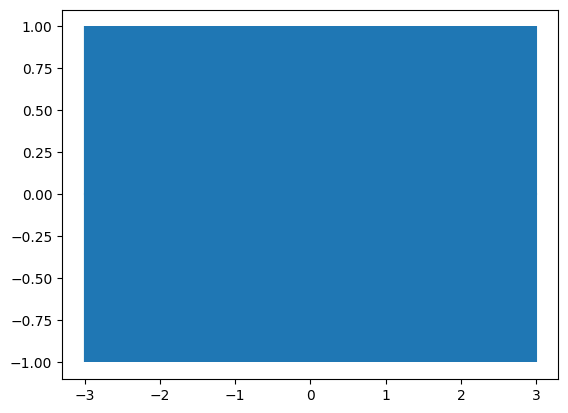

In [24]:
import matplotlib.pylab as plt
θ = [1, 10]
σ_0 = exponential_cov(0, 0, θ)
xpts = np.arange(-3, 3, step=0.01)
plt.errorbar(xpts, np.zeros(len(xpts)), yerr=σ_0, capsize=0);

Let's select an arbitrary starting point to sample, say $x=1$. Since there are no previous points, we can sample from an unconditional Gaussian:

In [25]:
x = [1.]
y = [np.random.normal(scale=σ_0)]
print(y)

[-1.7188201626024715]


We can now update our confidence band, given the point that we just sampled, using the covariance function to generate new point-wise intervals, conditional on the value $[x_0, y_0]$.

In [26]:
σ_1 = exponential_cov(x, x, θ)

In [27]:
def predict(x, data, kernel, params, sigma, t):
    k = [kernel(x, y, params) for y in data]
    Sinv = np.linalg.inv(sigma)
    y_pred = np.dot(k, Sinv).dot(t)
    sigma_new = kernel(x, x, params) - np.dot(k, Sinv).dot(k)
    return y_pred, sigma_new

x_pred = np.linspace(-3, 3, 1000)
predictions = [predict(i, x, exponential_cov, θ, σ_1, y) for i in x_pred]

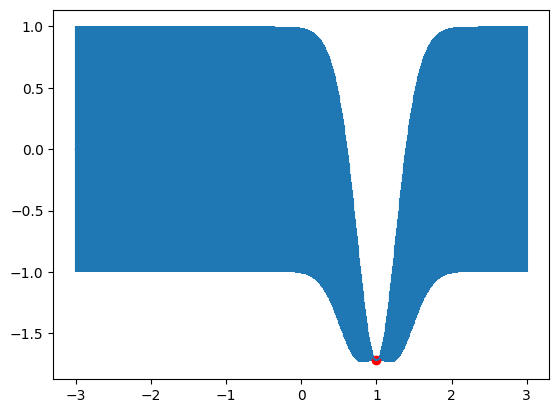

In [28]:
y_pred, sigmas = np.transpose(predictions)
plt.errorbar(x_pred, y_pred, yerr=sigmas, capsize=0)
plt.plot(x, y, "ro");

So conditional on this point, and the covariance structure we have specified, we have essentially constrained the probable location of additional points. Let's now sample another:

In [29]:
m, s = conditional([-0.7], x, y, θ)
y2 = np.random.normal(m, s)
print(y2)

-0.6617610702317862


This point is added to the realization, and can be used to further update the location of the next point.

In [30]:
x.append(-0.7)
y.append(y2)
σ_2 = exponential_cov(x, x, θ)
predictions = [predict(i, x, exponential_cov, θ, σ_2, y) for i in x_pred]

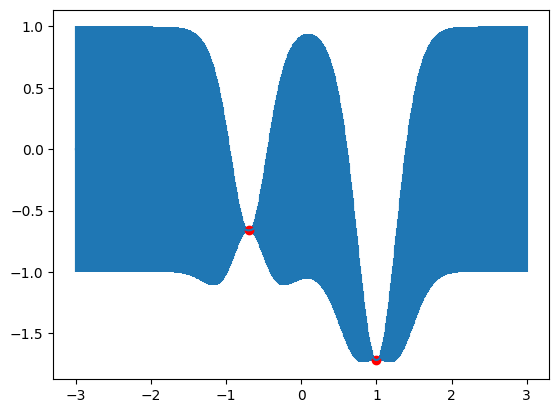

In [31]:
y_pred, sigmas = np.transpose(predictions)
plt.errorbar(x_pred, y_pred, yerr=sigmas, capsize=0)
plt.plot(x, y, "ro");

Of course, sampling sequentially is just a heuristic to demonstrate how the covariance structure works. We can just as easily sample several points at once:

In [32]:
x_more = [-2.1, -1.5, 0.3, 1.8, 2.5]
mu, s = conditional(x_more, x, y, θ)
y_more = np.random.multivariate_normal(mu, s)
print(y_more)

[-0.3667858  -0.12098627  0.67137127  0.99442827  1.47324489]


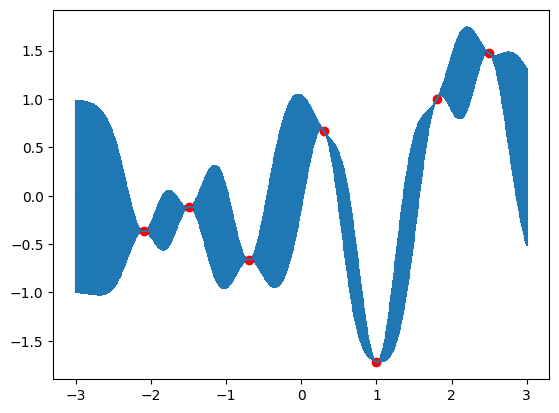

In [33]:
x += x_more
y += y_more.tolist()
σ_new = exponential_cov(x, x, θ)
predictions = [predict(i, x, exponential_cov, θ, σ_new, y) for i in x_pred]
y_pred, sigmas = np.transpose(predictions)
plt.errorbar(x_pred, y_pred, yerr=sigmas, capsize=0)
plt.plot(x, y, "ro");

So as the density of points becomes high, it results in a realization (sample function) from the prior GP.